<a href="https://colab.research.google.com/github/jamiroquai1225/Anomaly-Detection/blob/main/anomaly_detection_of_the_time_series_data_in_jeju_seaport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import pandas as pd

In [13]:
data = '/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/data/port.xlsx'

In [14]:
data_df = pd.read_excel(data)
data_df

,time,cargo
0,2000-01,41357
1,2000-02,48615
2,2000-03,41036
3,2000-04,33452
4,2000-05,36137
...,...,...
279,2023-04,1564123
280,2023-05,1513617
281,2023-06,1470733
282,2023-07,1373600


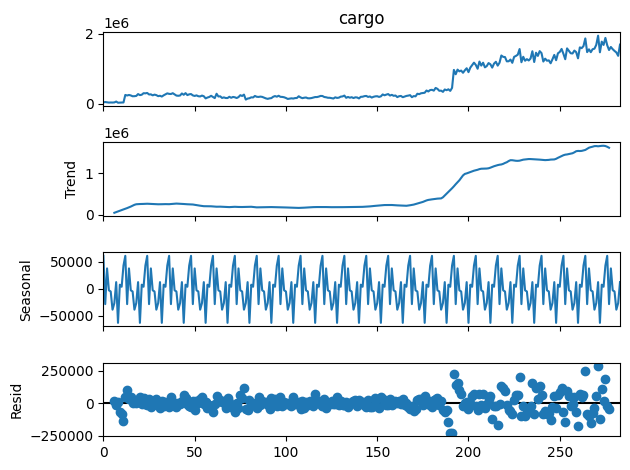

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform additive decomposition
decomp = seasonal_decompose(data_df['cargo'], period=12)

# Plot decomposition
decomp.plot();
plt.tight_layout();

# 시계열 이상치 탐지 ver.1

In [20]:
data_df.loc[:,'time'] = pd.to_datetime(data_df.time)

<ipython-input-20-8c5d9a866fd5>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_df.loc[:,'time'] = pd.to_datetime(data_df.time)


In [21]:
data_df

,time,cargo
0,2000-01-01,41357
1,2000-02-01,48615
2,2000-03-01,41036
3,2000-04-01,33452
4,2000-05-01,36137
...,...,...
279,2023-04-01,1564123
280,2023-05-01,1513617
281,2023-06-01,1470733
282,2023-07-01,1373600


In [22]:
data_df.isna().sum()

time     0
cargo    0
dtype: int64

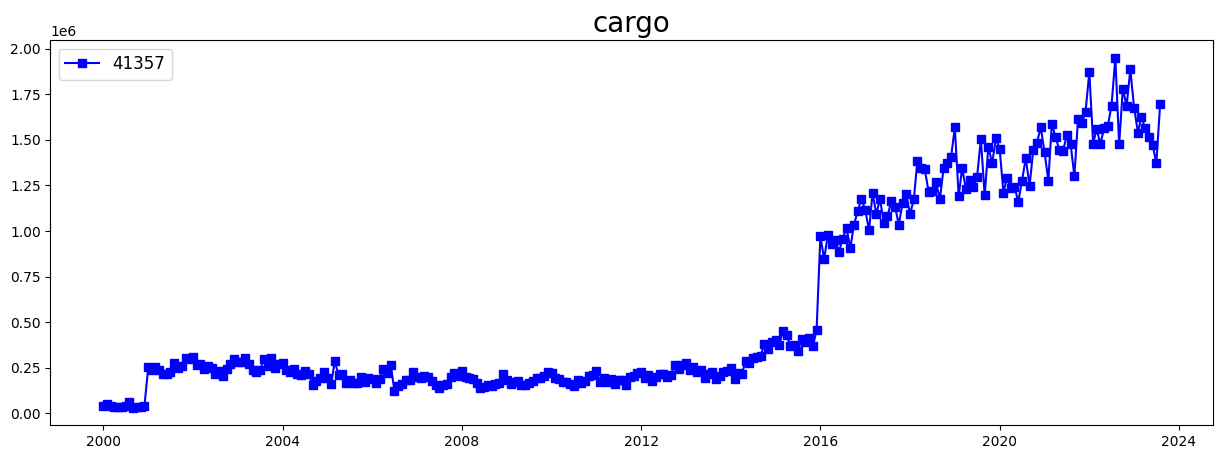

In [23]:
from matplotlib.pylab import rcParams
plt.rcParams["figure.figsize"] = (15,5)
plt.title('cargo', fontsize=20)
plt.plot(data_df.time, data_df.cargo, marker='s', color='b')
plt.legend(data_df['cargo'], fontsize=12, loc='best')

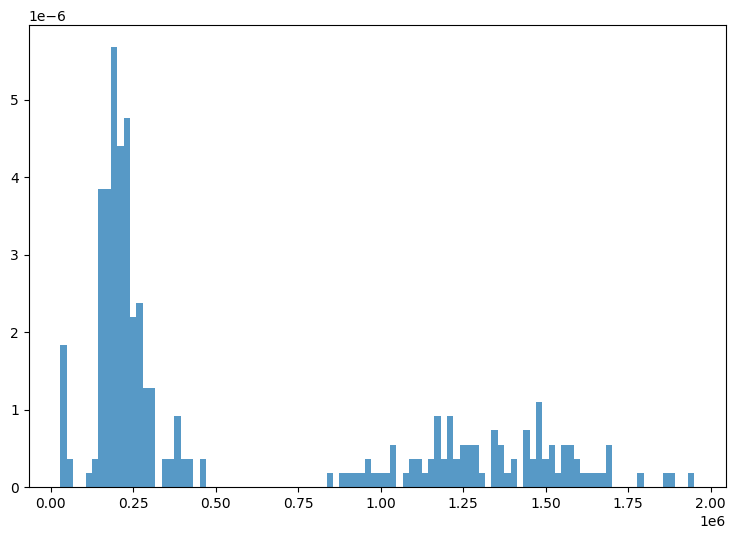

In [24]:
# 해결 - Unsupervised z-test
# 데이터가 정규분포를 따르는지 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(data_df.cargo, 100, density=True, alpha=0.75)

In [27]:
from statsmodels.stats.weightstats import ztest
r = result.resid.values
st, p = ztest(r)
print(st,p)

-0.3239493338126083 0.7459763931713185


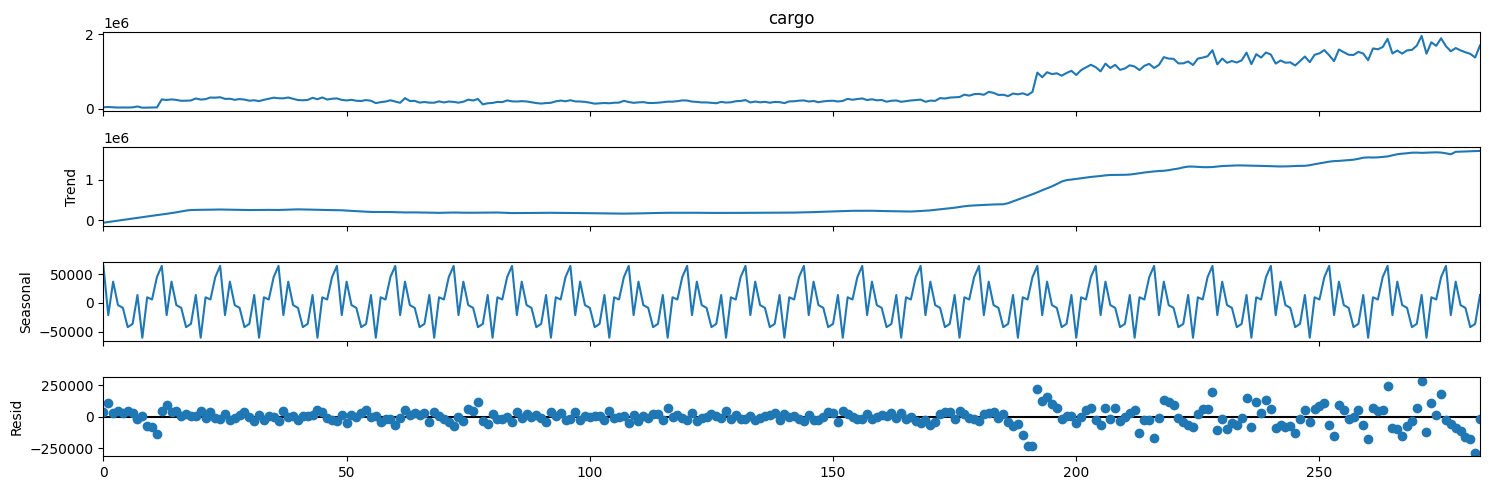

In [26]:
# Time series decomposition 시계열 데이터 중에서 정규분포에 가까운 데이터를 뽑아내는 방법

# additive 방법

from statsmodels.tsa.seasonal import seasonal_decompose

# 계절적 성분 50일로 가정
# extrapolate_trend='freq' : Trend 성분을 만들기 위한 rolling window 때문에 필연적으로 trend, resid에는 Nan 값이 발생하기 때문에, 이 NaN값을 채워주는 옵션
result = seasonal_decompose(data_df.cargo, model='additive', two_sided=True,
                            period=12, extrapolate_trend='freq')
result.plot()
plt.show()

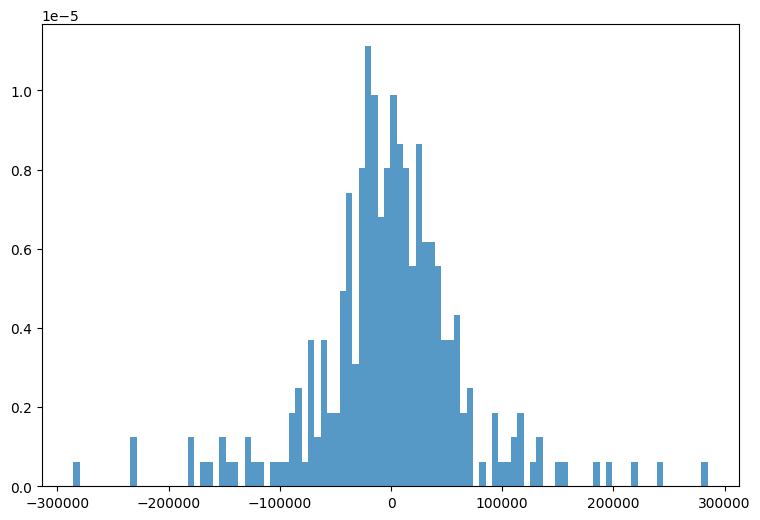

In [ ]:
# Residual의 분포 확인
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(result.resid, 100, density=True, alpha=0.75)

In [ ]:
# z-test를 통해 숫자로 다시 확인
# p-value가 0.05이상으로 나오면, 데이터 분포가 정규분포를 잘 따르고 있음
r = result.resid.values
st, p = ztest(r)
print(st,p)  # -0.6804023554131796 0.4962497300226193

-0.3239493338126083 0.7459763931713185


In [ ]:
# 평균과 표준편차 출력
mu, std = result.resid.mean(), result.resid.std()
print("평균:", mu, "표준편차:", std)
# 평균: -0.3595321143716522 표준편차: 39.8661527194307

# 3-sigma(표준편차)를 기준으로 이상치 판단
print("이상치 갯수:", len(result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)]))
# 이상치 갯수: 71
data_df.time[result.resid[(result.resid>mu+3*std)|(result.resid<mu-3*std)].index]

평균: -1305.2147644399204 표준편차: 67899.10608486531
이상치 갯수: 6


190   2015-11-01
191   2015-12-01
192   2016-01-01
264   2022-01-01
271   2022-08-01
282   2023-07-01
Name: time, dtype: datetime64[ns]

In [ ]:
# Multi-variable Anomaly Detection - Clustering
# 데이터 전처리
def my_decompose(data_df, features, freq=12):
    trend = pd.DataFrame()
    seasonal = pd.DataFrame()
    resid = pd.DataFrame()

    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(data_df[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values

    return trend, seasonal, resid

# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(data_df, features=['cargo'])
tdf.describe()

,cargo
count,2.840000e+02
mean,5.806179e+05
std,5.471934e+05
min,-5.733346e+04
25%,1.873937e+05
50%,2.524854e+05
75%,1.141287e+06
max,1.718465e+06


In [ ]:
rdf.describe()

,cargo
count,284.000000
mean,-1580.759371
std,68555.518740
min,-301659.768491
25%,-29674.185167
50%,-93.105555
75%,31371.579437
max,285128.936151


In [ ]:
# 표준정규화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(rdf)
print(scaler.mean_)
# [-0.40184982  -0.38035856  -0.39874878  -0.37402025 -195.40645742]

norm_rdf = scaler.transform(rdf)

In [ ]:
# clustering : k-means로 이상치 탐지
# k-means를 이용해서 정상 데이터그룹과 이상치 데이터 그룹을 분류함
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=2, random_state=0).fit(norm_rdf)
print(kmeans.labels_) # 분류된 라벨은 이렇게 kemans.labels_ 로 확인
# [1 1 1 ... 0 0 0]


# 라벨은 몇번 그룹인지 뜻한다.
# return_counts=True : 몇개의 샘플이 몇번 그룹에 할당되었는지 확인
lbl, cnt = np.unique(kmeans.labels_,return_counts=True)
print(lbl) # [0 1]  -> 0번 그룹, 1번 그룹으로 나뉨
print(cnt) # [3258 2434]  -> 0번그룹에 3258, 1번그룹에 2434

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

In [ ]:
# 이상치 날짜 탐색
data_df[(kmeans.labels_==2)|(kmeans.labels_==8)|(kmeans.labels_==11)]

In [ ]:
data_df.describe()

,cargo
count,2.840000e+02
mean,5.790365e+05
std,5.471714e+05
min,2.938700e+04
25%,1.940888e+05
50%,2.464365e+05
75%,1.161358e+06
max,1.950943e+06


In [ ]:
# 각 그룹별 특징
pd.DataFrame(kmeans.cluster_centers_, columns=['cargo'])

,cargo
0,0.464663
1,-0.885858
2,3.883281
3,-2.606863
4,1.548892
5,-0.196812
6,0.115536
7,-1.317686
8,-3.352715
9,2.070618


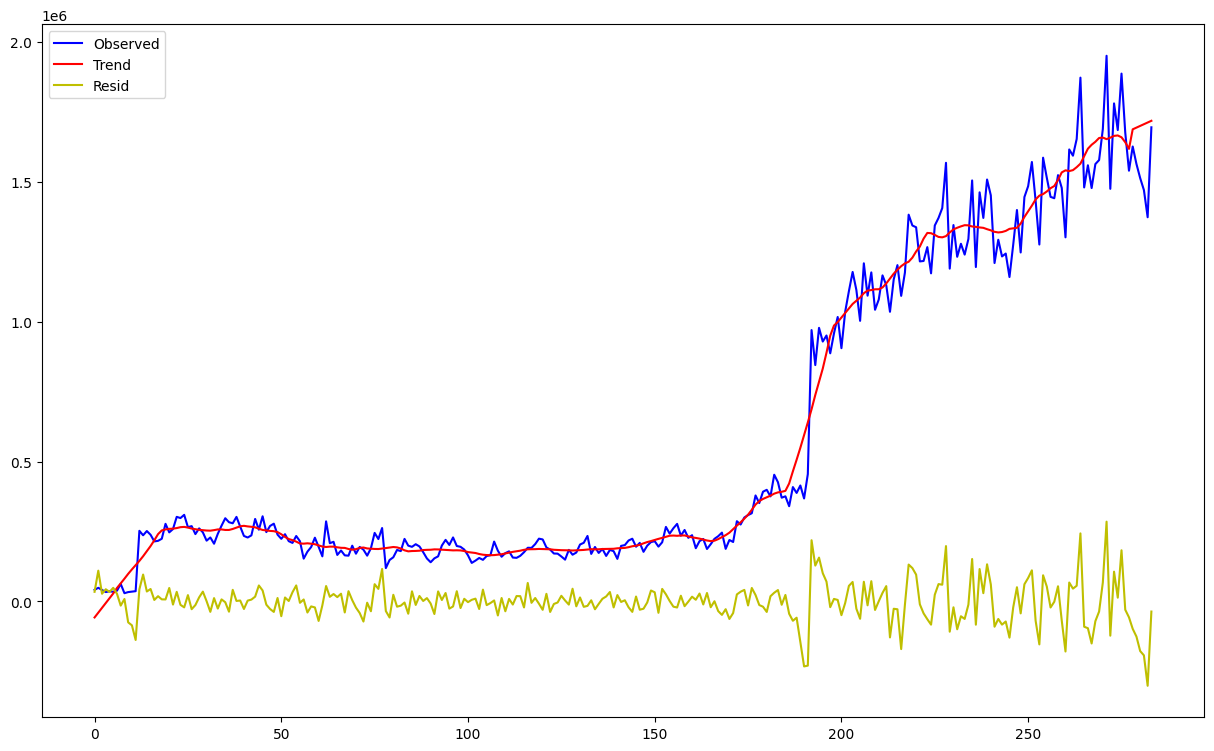

In [ ]:
# 파랑 : 실제 화물량, 빨갱 : 트렌드, 노랑: 잔차
# 잔차 등락에 따라 이상치를 탐색함
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(111)
data_df.cargo.plot(ax=ax, label='Observed', legend=True, color='b')
tdf.cargo.plot(ax=ax, label='Trend', legend=True, color='r')
rdf.cargo.plot(ax=ax,label='Resid', legend=True, color='y')
plt.show()

In [ ]:
# clustering : DBSCAN으로 이상치 탐지
from sklearn.cluster import DBSCAN

clustering = DBSCAN(eps=0.7, min_samples=2).fit(norm_rdf)
print(clustering)  # BSCAN(eps=0.7, min_samples=2)
print(clustering.labels_)  # [0 0 0 ... 0 0 0]

lbl, cnt = np.unique(clustering.labels_,return_counts=True)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

DBSCAN(eps=0.7, min_samples=2)
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0]


['group:-1-count:1', 'group:0-count:283']

# Auto encoder

In [29]:
# LSTM 을 이용한 오토인코더 모델 만들기
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import StandardScaler

In [34]:
# 모델 재현성을 위해 난수 시드설정
tf.random.set_seed(777)
np.random.seed(777)

# 데이터 전처리 - 하이퍼 파라미터
window_size = 10
batch_size = 32
features = ['cargo']
n_features = len(features)
TRAIN_SIZE = int(len(data_df)*0.7)

# 데이터 전처리 - 표준정규분포화
scaler = StandardScaler()
scaler = scaler.fit(data_df.loc[:TRAIN_SIZE,features].values)
scaled = scaler.transform(data_df[features].values)

# keras TimeseriesGenerator를 이용해 데이터셋 만들기
train_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size= batch_size,
    shuffle=False,
    start_index=0,
    end_index=None,
)

valid_gen = TimeseriesGenerator(
    data = scaled,
    targets = scaled,
    length = window_size,
    stride=1,
    sampling_rate=1,
    batch_size=batch_size,
    shuffle=False,
    start_index=TRAIN_SIZE,
    end_index=None,
)

print(train_gen[0][0].shape)  # (32, 10, 5)
print(train_gen[0][1].shape)  # (32, 5)


# 모델만들기
# 2개 층의 LSTM으로 인코더 만듬
# RepeatVector는 input을 window_size만큼 복사해줌
model = Sequential([
    # >> 인코더 시작
    LSTM(64, activation='relu', return_sequences=True, input_shape=(window_size, n_features)),
    LSTM(16, activation='relu', return_sequences=False),
    ## << 인코더 끝
    ## >> Bottleneck
    RepeatVector(window_size),
    ## << Bottleneck
    ## >> 디코더 시작
    LSTM(16, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(n_features)
    ## << 디코더 끝
])


# 체크포인트
# 학습을 진행하며 validation 결과가 가장 좋은 모델을 저장함
checkpoint_path = os.getenv('HOME')+'/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/'
checkpoint = ModelCheckpoint(checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

# 얼리스탑
# 학습을 진행하며 validation 결과가 나빠지면 스톱. patience 횟수만큼은 참고 지켜봄
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.compile(loss='mae', optimizer='adam',metrics=["mae"])


hist = model.fit(train_gen,
          validation_data=valid_gen,
          steps_per_epoch=len(train_gen),
          validation_steps=len(valid_gen),
          epochs=50,
          callbacks=[checkpoint, early_stop])


model.load_weights(checkpoint_path)

(32, 10, 1)
(32, 1)
Epoch 1/50
7/9 [======================>.......] - ETA: 0s - loss: 2.4903 - mae: 2.4903
Epoch 1: val_loss improved from inf to 7.63272, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/
9/9 [==============================] - 6s 122ms/step - loss: 2.6577 - mae: 2.6577 - val_loss: 7.6327 - val_mae: 7.6327
Epoch 2/50
7/9 [======================>.......] - ETA: 0s - loss: 1.4039 - mae: 1.4039
Epoch 2: val_loss improved from 7.63272 to 7.51668, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 적용/
9/9 [==============================] - 0s 31ms/step - loss: 2.6295 - mae: 2.6295 - val_loss: 7.5167 - val_mae: 7.5167
Epoch 3/50
7/9 [======================>.......] - ETA: 0s - loss: 3.2914 - mae: 3.2914
Epoch 3: val_loss improved from 7.51668 to 5.13900, saving model to /root/content/drive/MyDrive/논문/항만 물동량 이상치 탐지 : anomaly detection의 저

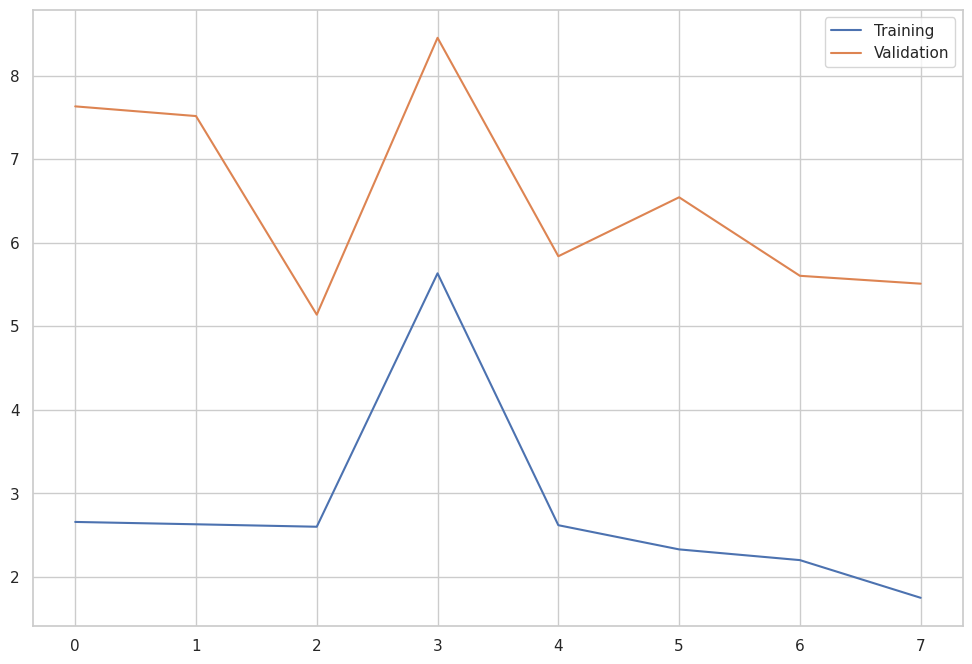

In [35]:
# 안정적으로 Training loss 가 수렴하고 Validation loss 가 발산하지 않음을 확인
# 시계열 데이터를 window_size 만큼 밀어가면서 예측하는 모델이라 train_gen의 길이는 원본 df의 길이보다 window_size만큼 짧음
# 예측 결과와 비교할 때는 scaled의 앞에서 window_size만큼을 건너뛰어야함

fig = plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'], label='Training')
plt.plot(hist.history['val_loss'], label='Validation')
plt.legend()

9/9 [==============================] - 1s 6ms/step


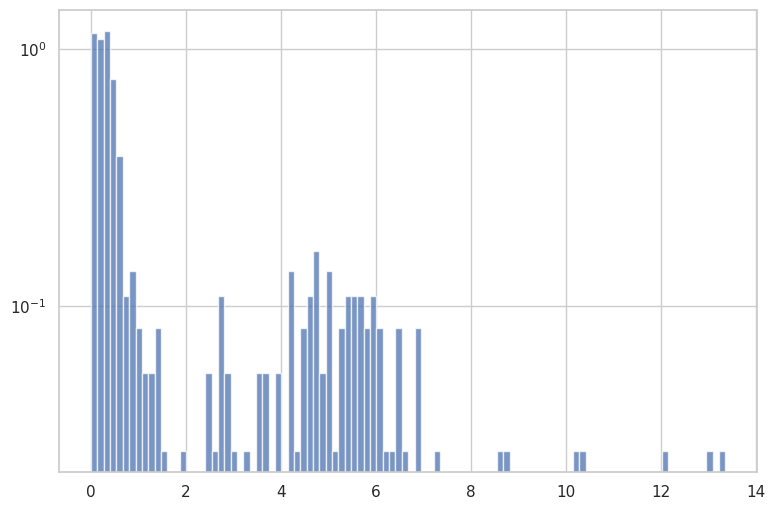

In [36]:
# 예측 결과를 pred 로, 실적 데이터를 real로 받음
pred = model.predict(train_gen)
real = scaled[window_size:]

mae_loss = np.mean(np.abs(pred-real), axis=1)

# 샘플 개수가 많기 때문에 y축을 로그 스케일로 그림
fig, ax = plt.subplots(figsize=(9,6))
_ = plt.hist(mae_loss, 100, density=True, alpha=0.75, log=True)

In [ ]:
# mae_loss가 3 이상으로 동떨어진 샘플이 보임

In [37]:
import copy

test_df = copy.deepcopy(data_df.loc[window_size:]).reset_index(drop=True)
test_df['Loss'] = mae_loss

threshold = 3
test_df.loc[test_df.Loss>threshold]

,time,cargo,Loss
182,2016-01-01,970139,4.735890
183,2016-02-01,845055,3.913695
184,2016-03-01,978233,4.780404
185,2016-04-01,929163,4.449181
186,2016-05-01,950769,4.577588
...,...,...,...
269,2023-04-01,1564123,12.112311
270,2023-05-01,1513617,13.352136
271,2023-06-01,1470733,13.082560
272,2023-07-01,1373600,10.244766


In [38]:
# 기준치를 더 낮춰서 보다 많은 이상치 찾음
threshold = 0.3
test_df.loc[test_df.Loss>threshold]

,time,cargo,Loss
0,2000-11-01,34931,1.339882
1,2000-12-01,36593,1.328972
12,2001-11-01,302322,0.389908
13,2001-12-01,298075,0.360677
14,2002-01-01,309514,0.433369
...,...,...,...
269,2023-04-01,1564123,12.112311
270,2023-05-01,1513617,13.352136
271,2023-06-01,1470733,13.082560
272,2023-07-01,1373600,10.244766


In [ ]:
# 그래프를 그려서 이상치 찾음
fig = plt.figure(figsize=(12, 15))

# 가격들 그래프입니다
ax = fig.add_subplot(311)
ax.set_title('cargo')
plt.plot(test_df.time, test_df.cargo, linewidth=0.5, alpha=0.75, label='cargo')
plt.plot(test_df.time, test_df.cargo, 'or', markevery=[mae_loss>threshold])

ax = fig.add_subplot(312)
ax.set_title('Loss')
plt.plot(test_df.time, test_df.Loss, linewidth=0.5, alpha=0.75, label='Loss')
plt.plot(test_df.time, test_df.Loss, 'or', markevery=[mae_loss>threshold])

# 수요예측을 활용한 anomaly detection

In [40]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [41]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [51]:
#read data
data = data_df

In [43]:
#infer the frequency of the data
data = data.asfreq(pd.infer_freq(data.index))

In [44]:
data

,time,cargo
1970-01-01 00:00:00.000000000,NaT,NaN
1970-01-01 00:00:00.000000001,NaT,NaN
1970-01-01 00:00:00.000000002,NaT,NaN
1970-01-01 00:00:00.000000003,NaT,NaN
1970-01-01 00:00:00.000000004,NaT,NaN
...,...,...
1970-01-01 00:00:00.000000279,NaT,NaN
1970-01-01 00:00:00.000000280,NaT,NaN
1970-01-01 00:00:00.000000281,NaT,NaN
1970-01-01 00:00:00.000000282,NaT,NaN


In [45]:
import datetime
idx = pd.IndexSlice

In [46]:
start_date = datetime(2000,01,01)
end_date = datetime(2023,8,1)
data1 = data[start_date:end_date]

SyntaxError: ignored

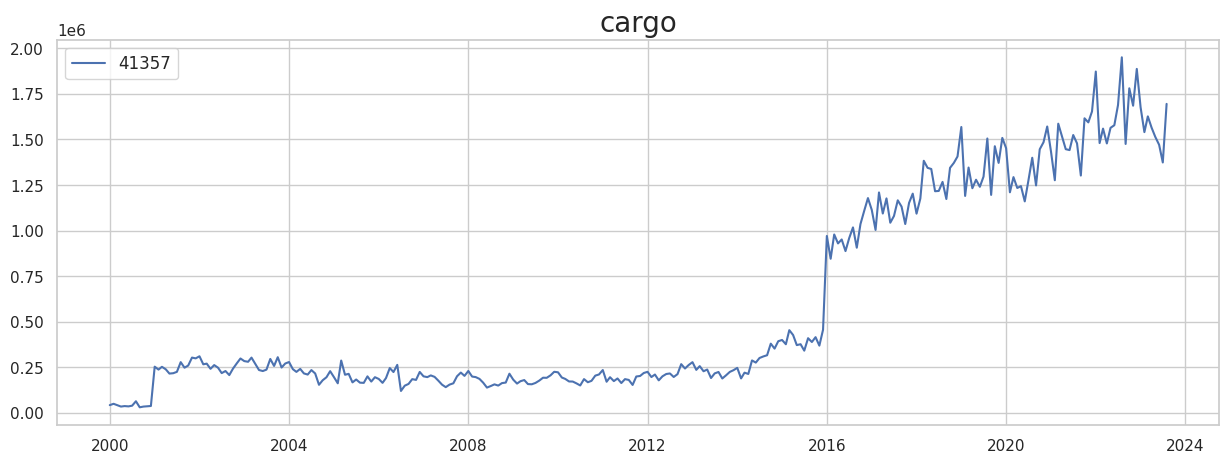

In [47]:
from matplotlib.pylab import rcParams
plt.rcParams["figure.figsize"] = (15,5)
plt.title('cargo', fontsize=20)
plt.plot(data_df.time, data_df.cargo, color='b')
plt.legend(data_df['cargo'], fontsize=12, loc='best')

In [48]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [53]:
df = data
df = df.rename(columns={'time': 'ds', 'cargo': 'y'})[['ds', 'y']]
df['ds'] =df['ds'].dt.tz_localize(None)
df = df.set_index('ds')
print(df)

                  y
ds                 
2000-01-01    41357
2000-02-01    48615
2000-03-01    41036
2000-04-01    33452
2000-05-01    36137
...             ...
2023-04-01  1564123
2023-05-01  1513617
2023-06-01  1470733
2023-07-01  1373600
2023-08-01  1695185

[284 rows x 1 columns]


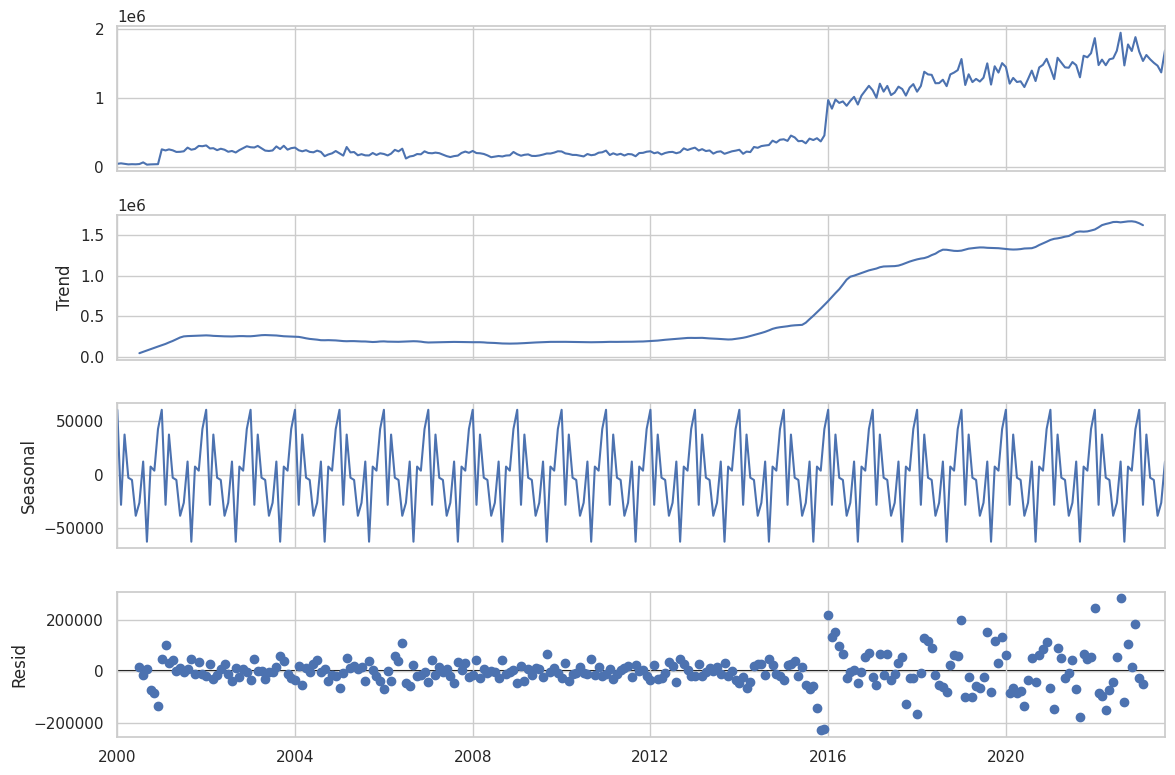

In [54]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)

result = seasonal_decompose(df, model='additive')
fig = result.plot()

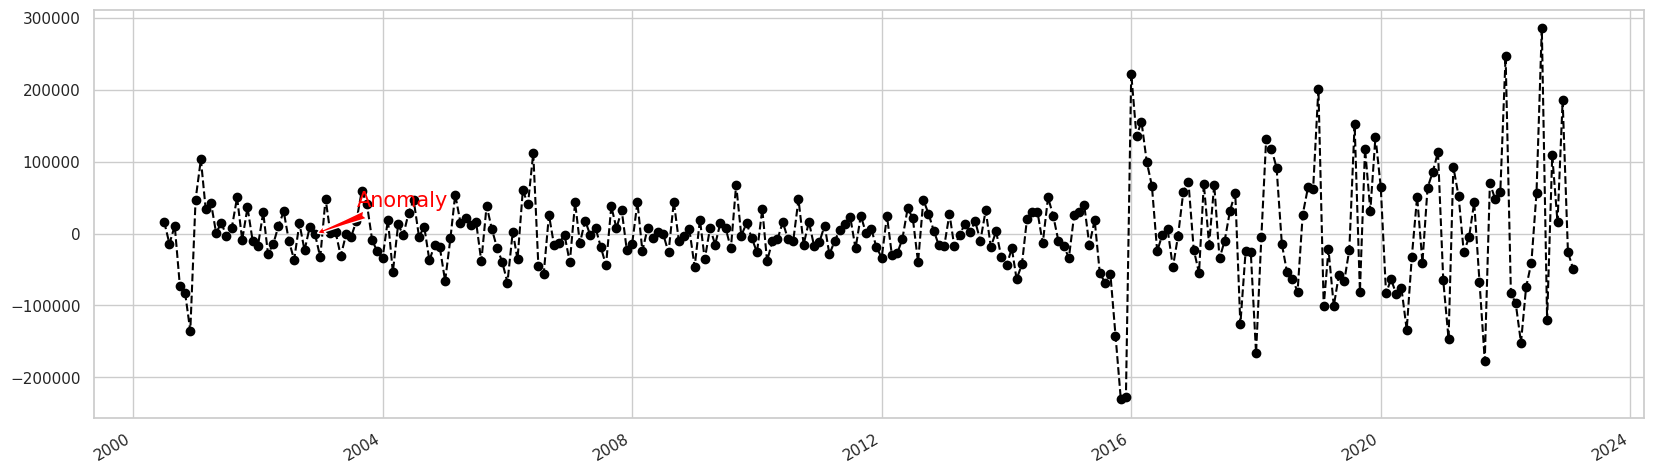

In [55]:
plt.rc('figure',figsize=(20,6))
plt.rc('font',size=15)

fig, ax = plt.subplots()
x = result.resid.index
y = result.resid.values
ax.plot_date(x, y, color='black',linestyle='--')

ax.annotate('Anomaly', (mdates.date2num(x[35]), y[35]), xytext=(30, 20),
           textcoords='offset points', color='red',arrowprops=dict(facecolor='red',arrowstyle='fancy'))

fig.autofmt_xdate()
plt.show()


# isolation forest

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

<Axes: xlabel='ds'>

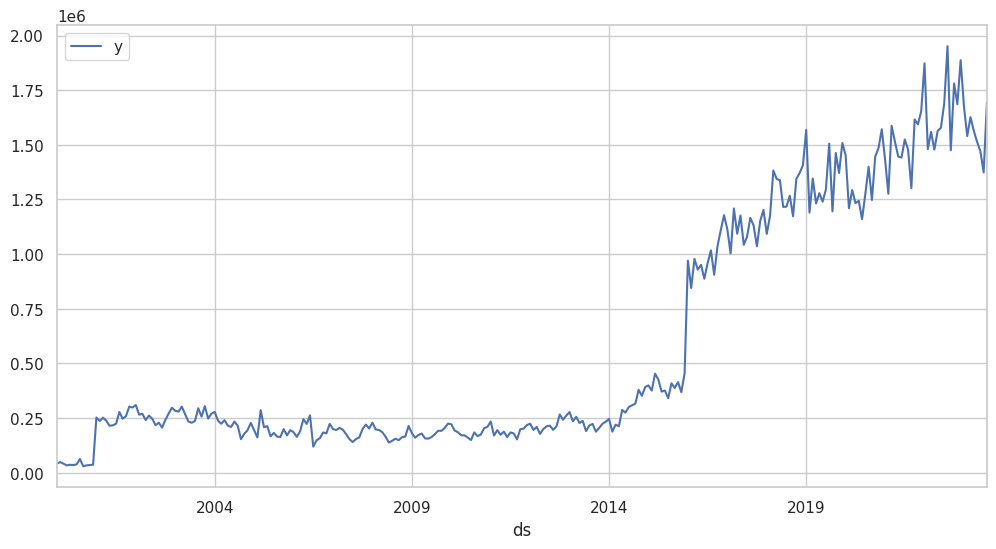

In [57]:
plt.rc('figure',figsize=(12,6))
plt.rc('font',size=15)
df.plot()

In [58]:
outliers_fraction = float(.01)

In [59]:
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df.values.reshape(-1, 1))
data = pd.DataFrame(np_scaled)

In [60]:
# train isolation forest
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)
IsolationForest(contamination=0.01)

IsolationForest(contamination=0.01)

In [ ]:
df

,y,anomaly
ds,,
2000-01-01,41357,1
2000-02-01,48615,1
2000-03-01,41036,1
2000-04-01,33452,1
2000-05-01,36137,1
...,...,...
2023-04-01,1564123,1
2023-05-01,1513617,1
2023-06-01,1470733,1


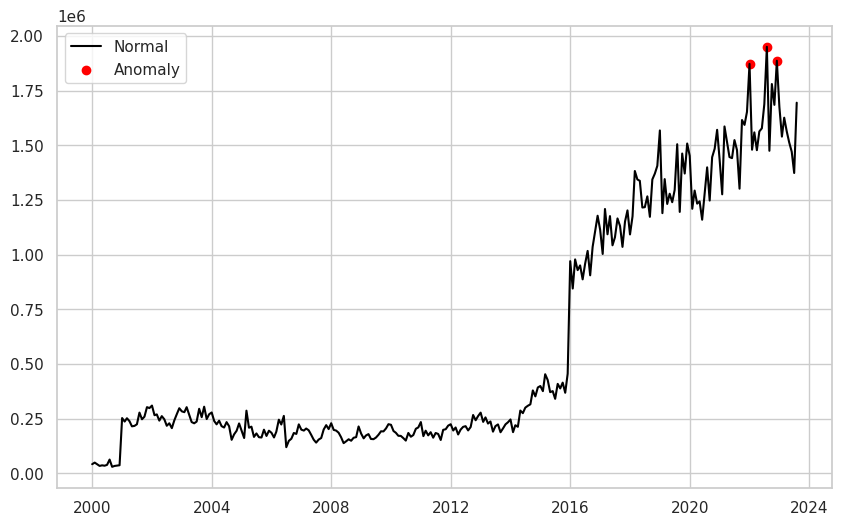

In [61]:
df['anomaly'] = model.predict(data)

# visualization
fig, ax = plt.subplots(figsize=(10,6))

a = df.loc[df['anomaly'] == -1, ['y']] #anomaly

ax.plot(df.index, df['y'], color='black', label = 'Normal')
ax.scatter(a.index,a['y'], color='red', label = 'Anomaly')
plt.legend()
plt.show();

# forecasting

In [ ]:
!pip install pmdarima

In [7]:
pip install prophet

In [ ]:
!pip install pystan~=2.14 # fbprophet 설치
!pip install cmdstanpy>=1.0.4
!pip install fbprophet

In [10]:
from prophet import Prophet

In [66]:
df

,y,anomaly
ds,,
2000-01-01,41357,1
2000-02-01,48615,1
2000-03-01,41036,1
2000-04-01,33452,1
2000-05-01,36137,1
...,...,...
2023-04-01,1564123,1
2023-05-01,1513617,1
2023-06-01,1470733,1


In [69]:
t = pd.DataFrame()
t['ds'] = df.index
t['y'] = df['y'].values

In [70]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
   m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
               seasonality_mode = 'additive',
               interval_width = interval_width,
               changepoint_range = changepoint_range)
   m = m.fit(dataframe)
   forecast = m.predict(dataframe)
   forecast['fact'] = dataframe['y'].reset_index(drop = True)
   return forecast

pred = fit_predict_model(t)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpttfevazz/jxt056ft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpttfevazz/8_fndjrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86499', 'data', 'file=/tmp/tmpttfevazz/jxt056ft.json', 'init=/tmp/tmpttfevazz/8_fndjrx.json', 'output', 'file=/tmp/tmpttfevazz/prophet_modellsd9gfv_/prophet_model-20231107082637.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [71]:
t

,ds,y
0,2000-01-01,41357
1,2000-02-01,48615
2,2000-03-01,41036
3,2000-04-01,33452
4,2000-05-01,36137
...,...,...
279,2023-04-01,1564123
280,2023-05-01,1513617
281,2023-06-01,1470733
282,2023-07-01,1373600


In [72]:
import altair as alt
#alt.renderers.enable('notebook')

In [ ]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'additive',
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

pred = fit_predict_model(t)

In [74]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']

    return forecasted

pred = detect_anomalies(pred)

In [75]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Anomaly Detection'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=30, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='Sales'),
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)

plot_anomalies(pred)

alt.LayerChart(...)

In [ ]:
!pip install pyod

In [77]:
import numpy as np
import pandas as pd
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data

contamination = 0.1  # percentage of outliers
n_train = 500  # number of training points
n_test = 500  # number of testing points
n_features = 25 # Number of features

X_train, y_train, X_test, y_test = generate_data(
    n_train=n_train, n_test=n_test,
    n_features= n_features,
    contamination=contamination,random_state=1234)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [81]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_train = pd.DataFrame(X_train)
X_test = StandardScaler().fit_transform(X_test)
X_test = pd.DataFrame(X_test)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(X_train)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'red', 1: 'blue'}
# Plot
import matplotlib.pyplot as plt
plt.scatter(X_train[0], X_train[1], c=y_train, alpha=1)
plt.title('Scatter plot')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [84]:
clf = AutoEncoder(hidden_neurons =[25, 2, 2, 25])
clf.fit(X_train)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 25)                650       
                                                                 
 dropout (Dropout)           (None, 25)                0         
                                                                 
 dense_2 (Dense)             (None, 25)                650       
                                                                 
 dropout_1 (Dropout)         (None, 25)                0         
                                                                 
 dense_3 (Dense)             (None, 25)                650       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_4 (Dense)             (None, 2)                

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=100,
      hidden_activation='relu', hidden_neurons=[25, 2, 2, 25],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x7f189bab27a0>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [ ]:
# Get the outlier scores for the train data
y_train_scores = clf.decision_scores_

# Predict the anomaly scores
y_test_scores = clf.decision_function(X_test)  # outlier scores
y_test_scores = pd.Series(y_test_scores)

# Plot it!
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.hist(y_test_scores, bins='auto')
plt.title("Histogram for Model Clf Anomaly Scores")
plt.show()

In [ ]:
df_test = X_test.copy()
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<4, 0, 1)
df_test['cluster'].value_counts()

t = df_test.groupby('cluster').mean()

In [90]:
df

,y,anomaly
ds,,
2000-01-01,41357,1
2000-02-01,48615,1
2000-03-01,41036,1
2000-04-01,33452,1
2000-05-01,36137,1
...,...,...
2023-04-01,1564123,1
2023-05-01,1513617,1
2023-06-01,1470733,1


In [ ]:
adjusted_data = df.copy()
adjusted_data.loc[curr_anomaly] =df[(df.index != df.anomaly) & (df.index < test_data.index[0])].mean()

In [99]:
df

,y,anomaly,time
ds,,,
2000-01-01,41357,1,NaT
2000-02-01,48615,1,NaT
2000-03-01,41036,1,NaT
2000-04-01,33452,1,NaT
2000-05-01,36137,1,NaT
...,...,...,...
2023-04-01,1564123,1,NaT
2023-05-01,1513617,1,NaT
2023-06-01,1470733,1,NaT


# anomaly detection using chat gpt

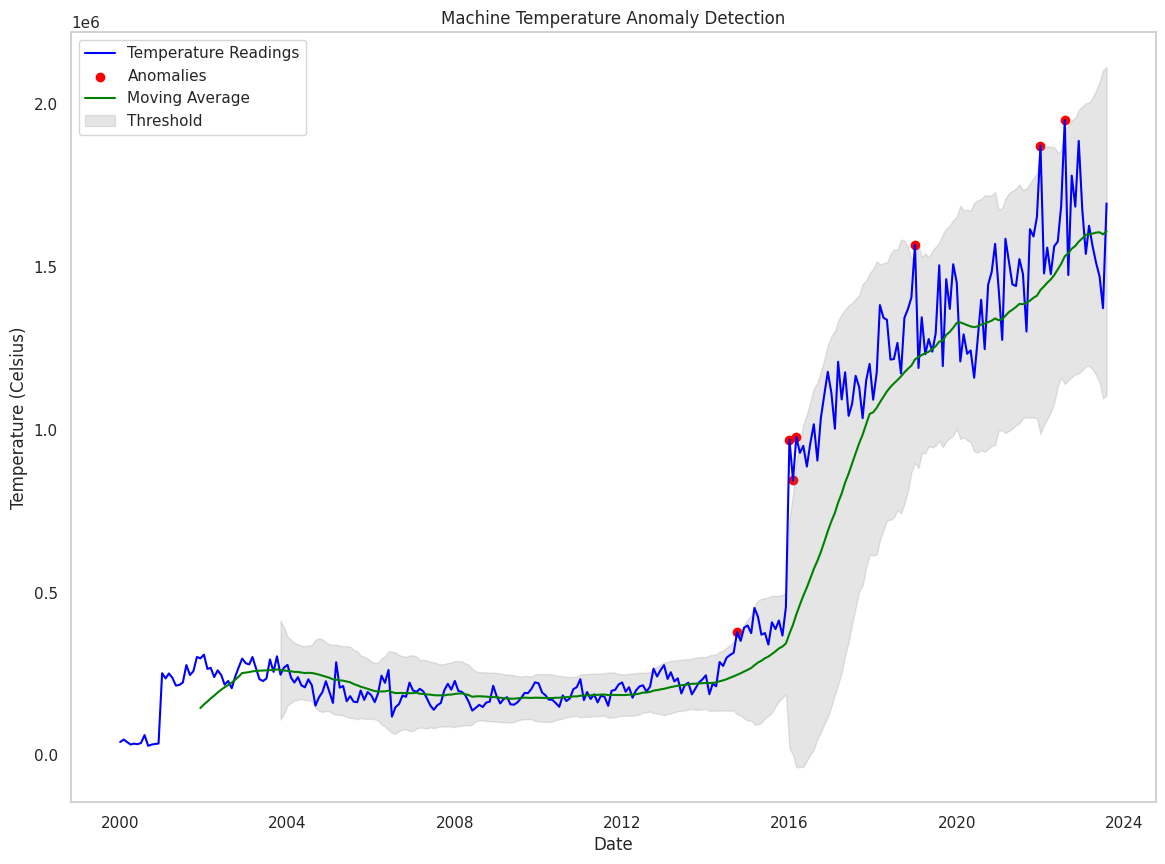

In [105]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset

# Convert the timestamp column to a datetime object
data_df['time'] = pd.to_datetime(data_df['time'])

# Calculate the moving average of the temperature readings
window_size = 24 # MODIFICATION, original was 50
ma = data_df['cargo'].rolling(window_size).mean()

# Calculate the deviation from the moving average
deviation = data_df['cargo'] - ma

# Calculate the standard deviation of the deviation
std_deviation = deviation.rolling(window_size).std()

# Calculate the threshold for anomaly detection
threshold = 3 * std_deviation

# Detect anomalies based on deviations from the moving average
anomalies = data_df[deviation.abs() > threshold]

# Plot the temperature readings and the anomalies
plt.subplots(figsize=(14, 10)) # MODIFICATION, inserted
plt.plot(data_df['time'], data_df['cargo'], color='blue', label='Temperature Readings')
plt.scatter(anomalies['time'], anomalies['cargo'], color='red', label='Anomalies')
plt.plot(data_df['time'], ma, color='green', label='Moving Average')
plt.fill_between(data_df['time'], ma-threshold, ma+threshold, color='gray', alpha=0.2, label='Threshold')
plt.legend()
plt.title('Machine Temperature Anomaly Detection')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid() # MODIFICATION, inserted
plt.show()

# Z-score

In [106]:
df = data_df

In [119]:
# Calculate the average of the temperature readings
mean = df['cargo'].mean()

# Calculate the deviation from the average
deviation = df['cargo'] - mean

# Calculate the standard deviation of the deviation
std_deviation = deviation.std() # same as we would calculate df['value'].std()

# Calculate Z-score - we don't use it directly, for reference only
z_score = deviation / std_deviation # z_score = (value-mean)/std

# Calculate the threshold for anomaly detection
threshold = 3 * std_deviation

# Detect anomalies based on deviations from the moving average
anomalies = df[deviation.abs() > threshold]

In [120]:
# calculate percentile limits
percent_limit = 0.3 # 99.7% is set
upper_threshold = df['cargo'].quantile((100-percent_limit/2)/100)
lower_threshold = df['cargo'].quantile(percent_limit/2/100)

# Detect anomalies based on percentile limits
anomalies_upper = df[df['cargo'] > upper_threshold]
anomalies_lower = df[df['cargo'] < lower_threshold]

# Isolation Forest

In [109]:
import pandas as pd
from sklearn.ensemble import IsolationForest

def detect_anomalies_with_isolation_forest(series):
    # Convert the series to a 2D NumPy array
    data = series.values.reshape(-1, 1)

    # Create an instance of the IsolationForest class
    #model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
    model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)

    # Fit the model to the data and predict anomalies
    model.fit(data)
    anomalies = model.predict(data)

    # Convert the predictions back to a Pandas series and return it
    anomalies_series = pd.Series(anomalies, index=series.index)
    return anomalies_series

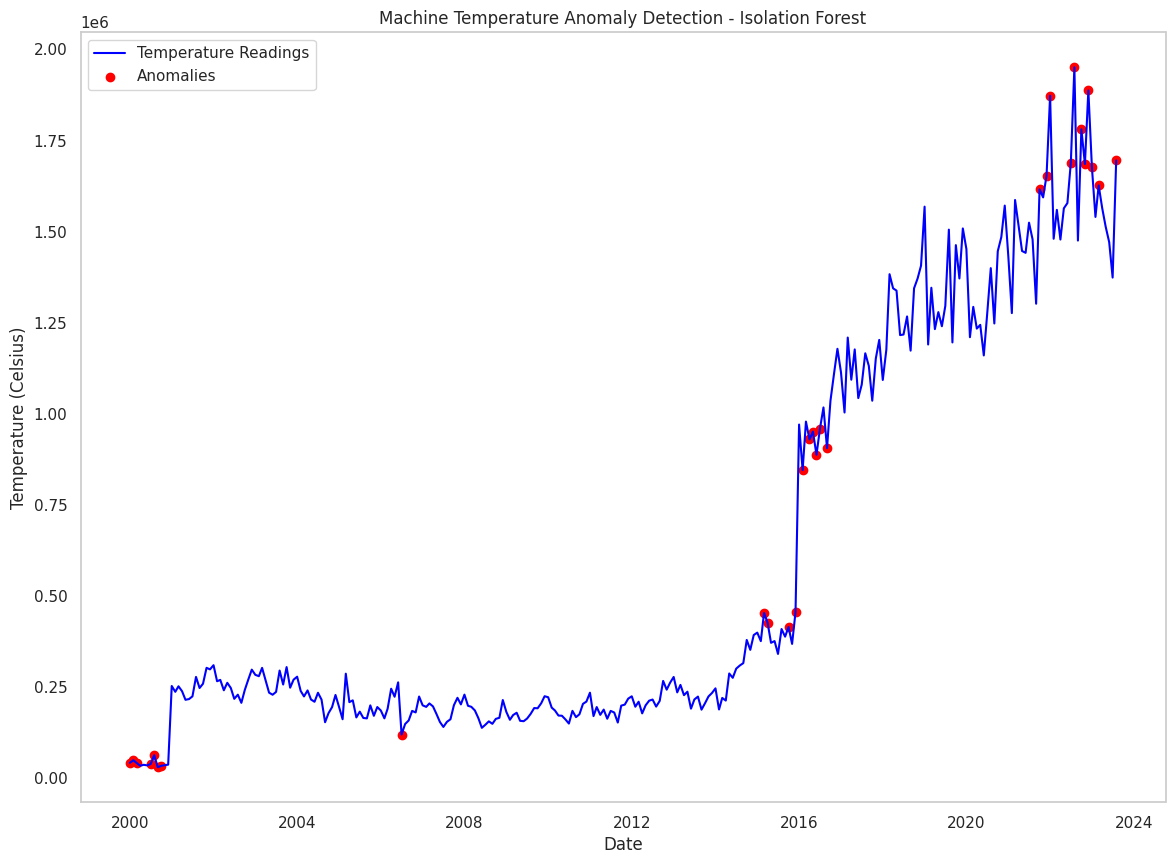

In [110]:
# Set the timestamp column as the index and convert to a series
series = data_df.set_index('time')['cargo'].squeeze()

# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies_with_isolation_forest(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(data_df['time'], data_df['cargo'], color='blue', label='Temperature Readings')
plt.scatter(anomalies[anomalies==-1].index, series[anomalies==-1].values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Isolation Forest')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

# Local Outlier Factor

In [115]:
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor

def detect_anomalies_with_local_outlier(series):
    #lof = LocalOutlierFactor(n_neighbors=10, contamination='auto')
    lof = LocalOutlierFactor(n_neighbors=24, contamination=0.1)
    X = series.values.reshape(-1,1)
    y_pred = lof.fit_predict(X)
    anomalies = X[y_pred==-1]
    return pd.Series(anomalies.flatten(), index=series.index[y_pred==-1])

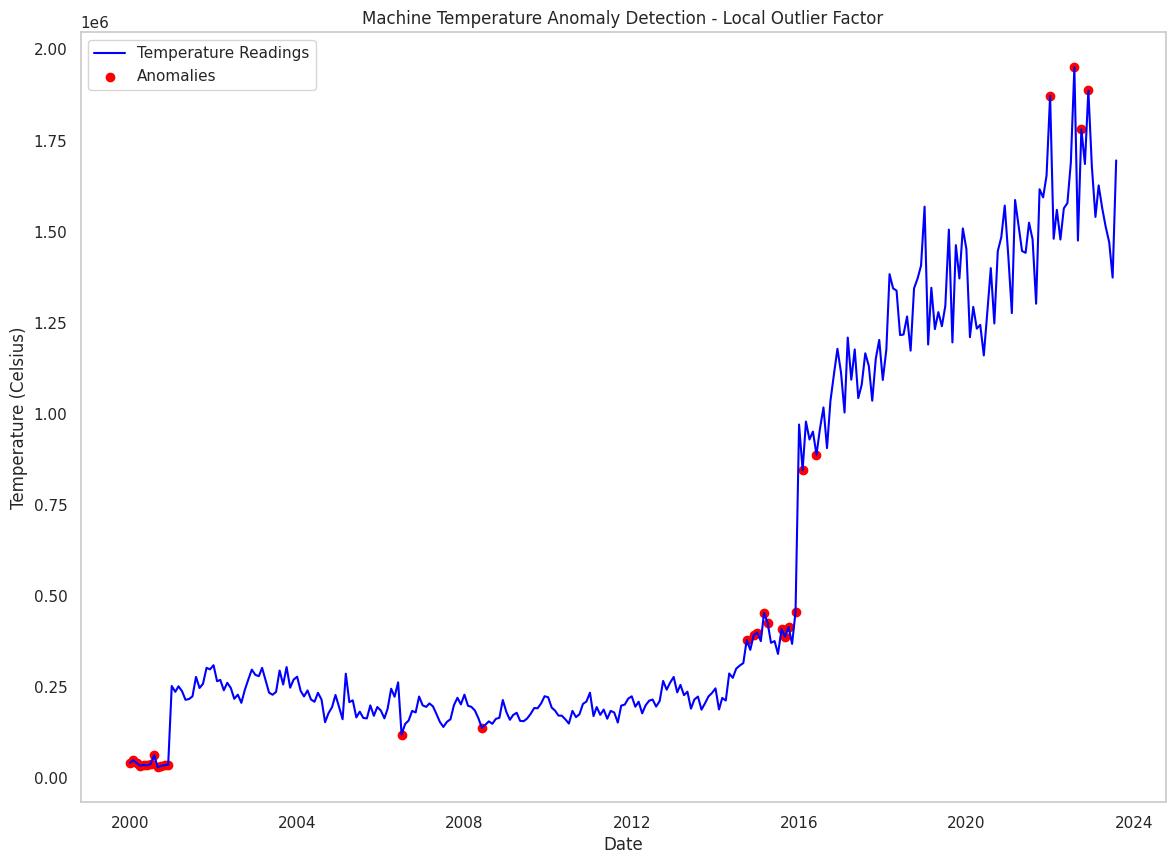

In [116]:
# Detect anomalies using the Isolation Forest algorithm
anomalies = detect_anomalies_with_local_outlier(series)

# Plot the original series and the detected anomalies
plt.subplots(figsize=(14, 10))
plt.plot(df['time'], df['cargo'], color='blue', label='Temperature Readings')
plt.scatter(anomalies.index, anomalies.values, color='red', label='Anomalies')
plt.legend()
plt.title('Machine Temperature Anomaly Detection - Local Outlier Factor')
plt.xlabel('Date')
plt.ylabel('Temperature (Celsius)')
plt.grid()
plt.show()

#Autoencoder algorithm

In [117]:
import numpy as np
import pandas as pd
from tensorflow import keras

def detect_anomalies_with_autoencoder(series, window_size=20, latent_dim=3, epochs=100):
    # Prepare the input data
    X = []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
    X = np.array(X)

    # Define the autoencoder architecture
    model = keras.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(window_size,)),
        keras.layers.Dense(latent_dim, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(window_size, activation='linear')
    ])

    # Train the autoencoder
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, X, epochs=epochs, verbose=0)

    # Use the trained autoencoder to detect anomalies
    X_pred = model.predict(X)
    mse = np.mean(np.power(X - X_pred, 2), axis=1)
    threshold = np.percentile(mse, 95)
    anomalies = series.iloc[window_size:][mse >= threshold]

    return anomalies

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Split the data into training and testing sets
train_series = series.loc['2000-01-01':'2022-12-01']
test_series = series.loc['2022-10-01':] # some overlapping - intentionally

# ---------------------- CHATGPT ---------------------- :
# Fit an ARIMA model to the training data
model = ARIMA(train_series.values, order=(3,1,1))
model_fit = model.fit()

# Make predictions on the testing data
predictions = model_fit.forecast(steps=len(test_series))[0] # resulting a single step prediction

# Calculate the residuals between the predicted and actual values
residuals = test_series.values - predictions

# Calculate the mean and standard deviation of the residuals
residual_mean = np.mean(residuals)
residual_std = np.std(residuals)

# Determine the threshold for anomaly detection
threshold = residual_mean + 2.5 * residual_std

# Identify anomalies in the testing data
anomalies = test_series[abs(residuals) > threshold]